# CUHK [STAT3009](https://www.bendai.org/STAT3009/) Notebook10(b): Top-K recommendation via AdaRank

## - Part 1: report `NDCG` for existing methods
## - Part 2: Using `AdaRank` to do `NDCG` optimization

## define a new evaluation metric ``NDCG``

In [2]:
from sklearn.metrics import ndcg_score

def ndcg_rs(test_pair, true_rating, pred_rating, k=10):
	ndcg = []
	user_lst = list(set(test_pair[:,0]))
	user_index = [np.where(test_pair[:,0] == user_tmp)[0] for user_tmp in user_lst]
	for user_tmp in user_lst:
		true_rating_tmp = true_rating[user_index[user_tmp]]
		pred_rating_tmp = pred_rating[user_index[user_tmp]]
		ndcg_tmp = ndcg_score([true_rating_tmp], [pred_rating_tmp], k=k)
		ndcg.append(ndcg_tmp)
	return np.mean(ndcg)

## Pre-process the ML-100K raw data
- check the `user_id` and `item_id`: mapping `item_id` to a continuous sequence based on `sklean.preprocessing`
- use `sklearn.model_selection.train_test_split` to generate `train` and `test` dataset

## Load additional ``side information``

ref: https://colab.research.google.com/github/lcharlin/80-629/blob/master/week4-PracticalSession/Introduction_to_ML.ipynb#scrollTo=4R717-S52plZ

In [3]:
import numpy as np
import pandas as pd
# load rating
df = pd.read_csv('./dataset/ml-latest-small/ratings.csv')
del df['timestamp']

movies_pd = pd.read_csv('./dataset/ml-latest-small/movies.csv', sep=',', engine='python')
movies_pd.sample(10)
# https://quantdare.com/learning-to-rank-with-tensorflow/

,movieId,title,genres
9594,175585,Shot Caller (2017),Action|Crime|Drama|Thriller
9056,141994,Saving Christmas (2014),Children|Comedy
8214,103609,Class Act (1992),Comedy
3762,5248,Smokey and the Bandit III (1983),Action|Comedy
6275,47566,Born to Kill (1947),Crime|Drama|Film-Noir
2442,3255,"League of Their Own, A (1992)",Comedy|Drama
9055,141928,Bloodsucking Bastards (2015),Comedy|Horror
8731,127114,The End of the Tour (2015),Drama
5488,26322,Gone in 60 Seconds (1974),Action|Crime|Drama
8947,136562,Steve Jobs (2015),Drama


## Feature engineering
- extract `year` and `genre` from the movies' side information
- For simplicity, if multiple genres exist, we just take the first one
- `Regex` to deal with the raw data [tutorial](https://regexone.com/) 

In [4]:
import re

year, genre = [], []
for i in range(len(movies_pd)):
	row = movies_pd.loc[i]
	year_tmp = re.findall('\d+', row['title'])
	if len(year_tmp) > 0:
		year.append(int(year_tmp[0]))
	else:
		year.append(np.nan)
	## take the first one as primary genere
	genre.append(row['genres'].split('|')[0])

movies_pd['year'], movies_pd['pGenre'] = year, genre
## delete original title and genres
del movies_pd['title']
del movies_pd['genres']
movies_pd.sample(10)

,movieId,year,pGenre
49,54,1995.0,Children
3150,4237,2000.0,Documentary
4598,6849,1970.0,Drama
8478,112911,2014.0,Action
3737,5197,1980.0,Drama
4101,5878,2002.0,Drama
3615,4964,2001.0,Adventure
9457,168090,2016.0,Animation
8538,115151,2014.0,Action
4877,7307,1985.0,Action


## [Missing data](https://machinelearningmastery.com/handle-missing-data-python/)
- Usually we impute the missing values by average, but there are some fancy methods, see [Imputation of missing values](https://scikit-learn.org/stable/modules/impute.html#impute).
- Use package `sklearn.impute.SimpleImputer`

In [5]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(movies_pd['year'].values.reshape(-1, 1))
movies_pd['year'] = imp_mean.transform(movies_pd['year'].values.reshape(-1, 1))

## Generate some additional side information for users and items
- Number of ratings
- Averaged ratings
- quantiles of the ratings (as a practice)

In [6]:
user_pd = pd.merge(left=df.groupby('userId')['rating'].mean(), 
					right=df.groupby('userId')['rating'].count(), on='userId', )
user_pd.columns = ['rating_mean', 'rating_count']
user_pd = user_pd.reset_index()

movie_rating_pd = pd.merge(left=df.groupby('movieId')['rating'].mean(), 
						right=df.groupby('movieId')['rating'].count(), on='movieId')
movie_rating_pd.columns	= ['rating_mean', 'rating_count']

movies_pd = pd.merge(left=movie_rating_pd, right=movies_pd, on='movieId')

print(user_pd.sample(10))
print(movies_pd.sample(10))

     userId  rating_mean  rating_count
85       86     3.928571            70
550     551     3.715447           123
561     562     4.093074           231
436     437     3.803279           122
149     150     3.576923            26
342     343     4.059322            59
256     257     3.200000            20
20       21     3.260722           443
269     270     3.200000            40
475     476     3.681159            69
      movieId  rating_mean  rating_count    year    pGenre
7020    68945     4.000000             2  1997.0    Action
8956   138036     3.472222            18  2015.0    Action
2284     3033     3.483051            59  1987.0    Comedy
5239     8609     3.250000             2  1923.0    Comedy
7121    71327     3.500000             1  2009.0     Drama
8126   102033     3.200000             5  2013.0    Action
4392     6464     2.000000             2  1997.0  Children
8170   103137     2.000000             2  2013.0     Crime
4949     7493     4.000000             2

## Pre-processing the dataset
- all continuous features should be standardized as mean 0, std 1
- all categorical features should be re-encoding to remove the missing ones

In [7]:
from sklearn import preprocessing
## pre-processing for users
user_cont = ['rating_mean', 'rating_count']
user_pd[user_cont] = preprocessing.StandardScaler().fit_transform(user_pd[user_cont])

## pre-processing for movies
movie_cont = ['rating_mean', 'rating_count', 'year']
movies_pd[movie_cont] = preprocessing.StandardScaler().fit_transform(movies_pd[movie_cont])

## encoding for categorical data 
from sklearn import preprocessing
le_genre = preprocessing.LabelEncoder()
movies_pd['pGenre'] = le_genre.fit_transform(movies_pd['pGenre'])

## joint encoding for userId and movieId
# !!! all dfs should share the same encoding for userId and movieId, respecitively!!!
le_movie = preprocessing.LabelEncoder()
le_user = preprocessing.LabelEncoder()

df['movieId'] = le_movie.fit_transform(df['movieId'])
df['userId'] = le_user.fit_transform(df['userId'])

movies_pd['movieId'] = le_movie.transform(movies_pd['movieId'])
user_pd['userId'] = le_user.transform(user_pd['userId'])

user_pd = user_pd.set_index('userId', drop=False)
movies_pd = movies_pd.set_index('movieId', drop=False)
## generate train / test dataset
from sklearn.model_selection import train_test_split
dtrain, dtest = train_test_split(df, test_size=0.33, random_state=42)
## save real ratings for test set for evaluation.
test_rating = np.array(dtest['rating'])
## remove the ratings in the test set to simulate prediction
dtest = dtest.drop(columns='rating')

In [11]:
# tran_pair, train_rating
train_pair = dtrain[['userId', 'movieId']].values
train_rating = dtrain['rating'].values
# test_pair
test_pair = dtest[['userId', 'movieId']].values
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

## Part 1: report `NDCG` for existing RS methods

In [12]:
def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

# baseline methods
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_ratings):
		self.glb_mean = np.mean(train_ratings)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred


class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=10, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is waring in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]                    
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is waring in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_pu = sum_pu + rating_tmp * self.Q[item_id,:]                    
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = abs(score_new - score_old) / score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class LFM_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = LFM(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

## Method 1: ``Regression``: rating ~ user_features + item_features

In [13]:
from sklearn.linear_model import LinearRegression

## convert genre to dummy variable
movies_pd_oh = pd.get_dummies(movies_pd, columns=['pGenre'])
## user_pd are all continuous features

train_joint_feats = np.hstack((user_pd.loc[train_pair[:,0]], movies_pd_oh.loc[train_pair[:,1]]))
test_joint_feats = np.hstack((user_pd.loc[test_pair[:,0]], movies_pd_oh.loc[test_pair[:,1]]))


reg = LinearRegression().fit(train_joint_feats, train_rating)
reg_rating = reg.predict(test_joint_feats)
train_rating_res = train_rating - reg.predict(train_joint_feats)
print('NDCG for linear regression based side info: %.3f' %ndcg_rs(test_pair, true_rating=test_rating, pred_rating=reg_rating))

NDCG for linear regression based side info: 0.902


## fit ``LFM`` after the regression

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.682, valid_rmse: 0.847
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.679, valid_rmse: 0.850
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.680, valid_rmse: 0.836
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.767, valid_rmse: 0.805
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.773, valid_rmse: 0.797
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.766, valid_rmse: 0.804
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 0.804, valid_rmse: 0.805
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 0.801, valid_rmse: 0.813
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 0.809, valid_rmse: 0.796
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 0.805, valid_rmse: 0.804
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 0.808, valid_rmse: 0.798
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 0.801, valid_rmse: 0.812
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 0.803, valid_rmse: 0.809
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 0.803, valid_rmse: 0.808
3-Fold

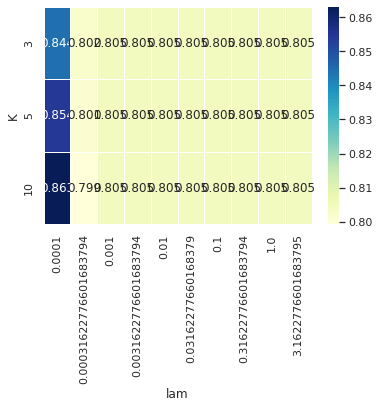

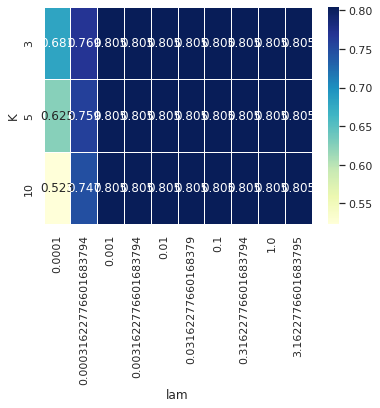

In [14]:
Ks, lams = [3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

In [22]:
## refit the best model with the full dataset
print(shiing_cv.best_model)
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing_best = LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing_best.fit(train_pair, train_rating_res)
pred_LFM = reg_rating + shiing_best.predict(test_pair)
print('NDCG for reg + LFM: %.3f' %ndcg_rs(test_pair, test_rating, pred_LFM))

K             10.000000
lam            0.000316
train_rmse     0.746628
valid_rmse     0.799235
Name: 21, dtype: float64
Fitting Reg-LFM: K: 10, lam: 0.00032
Reg-LFM: ite: 0; diff: 0.764 RMSE: 0.776
Reg-LFM: ite: 1; diff: 0.013 RMSE: 0.787
Reg-LFM: ite: 2; diff: 0.001 RMSE: 0.786
Reg-LFM: ite: 3; diff: 0.002 RMSE: 0.785
Reg-LFM: ite: 4; diff: 0.002 RMSE: 0.783
Reg-LFM: ite: 5; diff: 0.002 RMSE: 0.782
Reg-LFM: ite: 6; diff: 0.001 RMSE: 0.781
Reg-LFM: ite: 7; diff: 0.001 RMSE: 0.780
Reg-LFM: ite: 8; diff: 0.001 RMSE: 0.779
Reg-LFM: ite: 9; diff: 0.001 RMSE: 0.779
NDCG for reg + LFM: 0.904


## Method 2: ``NCF`` Model based on side information

### Step 1: Formulate neural network based on continuous and categorical features
- embedding for categorical features
- concatenate continuous features and all embedding vectors

In [16]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

2021-09-04 17:56:19.736895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-04 17:56:19.736953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
class SideNCF(keras.Model):
    def __init__(self, num_users, num_movies, num_genre, embedding_size, **kwargs):
        super(SideNCF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.genre_embedding = layers.Embedding(
            num_genre,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.concatenate = layers.Concatenate()
        self.dense1 = layers.Dense(100, name='fc-1', activation='relu')
        self.dense2 = layers.Dense(50, name='fc-2', activation='relu')
        self.dense3 = layers.Dense(1, name='fc-3', activation='relu')

    def call(self, inputs):
        cont_feats = inputs[0]
        cate_feats = inputs[1]
        user_vector = self.user_embedding(cate_feats[:,0])
        movie_vector = self.movie_embedding(cate_feats[:,1])
        genre_vector = self.genre_embedding(cate_feats[:,2])
        concatted_vec = self.concatenate([cont_feats, user_vector, movie_vector, genre_vector])
        fc_1 = self.dense1(concatted_vec)
        fc_2 = self.dense2(fc_1)
        fc_3 = self.dense3(fc_2)
        return fc_3

In [18]:
num_genre = movies_pd['pGenre'].max() + 1
model = SideNCF(num_users=n_user, num_movies=n_item, num_genre=num_genre, embedding_size=50)

metrics = [
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.RootMeanSquaredError(name='rmse')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=metrics
)

# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

2021-09-04 17:56:26.407710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-04 17:56:26.408107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-04 17:56:26.408210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-09-04 17:56:26.408287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-09-04 17:56:26.408363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

### Step 2: produce the continuous and categorical features for users and items

In [19]:
## find the continuous features and categorical features for user and item, respectively
movie_cont, movie_cate = ['rating_mean', 'rating_count'], ['movieId', 'pGenre']
user_cont, user_cate = ['rating_mean', 'rating_count'], ['userId']

train_cont_feats = np.hstack((user_pd.loc[train_pair[:,0]][user_cont], movies_pd.loc[train_pair[:,1]][movie_cont]))
train_cate_feats = np.hstack((user_pd.loc[train_pair[:,0]][user_cate], movies_pd.loc[train_pair[:,1]][movie_cate]))

test_cont_feats = np.hstack((user_pd.loc[test_pair[:,0]][user_cont], movies_pd.loc[test_pair[:,1]][movie_cont]))
test_cate_feats = np.hstack((user_pd.loc[test_pair[:,0]][user_cate], movies_pd.loc[test_pair[:,1]][movie_cate]))

### Step 3: Feed neural network with multi-source dataset

In [20]:
callbacks = [keras.callbacks.EarlyStopping( 
    monitor='val_rmse', min_delta=0, patience=5, verbose=1, 
    mode='auto', baseline=None, restore_best_weights=True)]

history = model.fit(
    x=[train_cont_feats, train_cate_feats],
    y=train_rating,
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_split=.2,
)

2021-09-04 17:56:36.649202: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
845/845 [==============================] - 4s 4ms/step - loss: 1.3711 - mae: 0.6899 - rmse: 0.9335 - val_loss: 0.8116 - val_mae: 0.6153 - val_rmse: 0.8117
Epoch 2/50
845/845 [==============================] - 4s 4ms/step - loss: 0.7447 - mae: 0.6132 - rmse: 0.8028 - val_loss: 0.7343 - val_mae: 0.6267 - val_rmse: 0.8163
Epoch 3/50
845/845 [==============================] - 4s 4ms/step - loss: 0.6965 - mae: 0.6092 - rmse: 0.7986 - val_loss: 0.6979 - val_mae: 0.6115 - val_rmse: 0.8030
Epoch 4/50
845/845 [==============================] - 3s 4ms/step - loss: 0.6807 - mae: 0.6054 - rmse: 0.7942 - val_loss: 0.6937 - val_mae: 0.6081 - val_rmse: 0.8032
Epoch 5/50
845/845 [==============================] - 4s 4ms/step - loss: 0.6693 - mae: 0.6024 - rmse: 0.7911 - val_loss: 0.6874 - val_mae: 0.6149 - val_rmse: 0.8043
Epoch 6/50
845/845 [==============================] - 4s 4ms/step - loss: 0.6604 - mae: 0.6002 - rmse: 0.7881 - val_loss: 0.6745 - val_mae: 0.6076 - val_rmse: 0.7989
Epoc

845/845 [==============================] - 4s 4ms/step - loss: 0.6310 - mae: 0.5699 - rmse: 0.7487 - val_loss: 0.7240 - val_mae: 0.6058 - val_rmse: 0.8091


In [23]:
## make prediction
pred_rating = model.predict([test_cont_feats, test_cate_feats]).flatten()
print(pred_rating)
print('NDCG: SideNCF: %.3f' %ndcg_rs(test_pair, true_rating=test_rating, pred_rating=pred_rating))

[3.751656  3.503004  2.6738782 ... 4.2373323 3.0226321 4.279232 ]
NDCG: SideNCF: 0.908


## Part 2: the `AdaRank` methods

## Step 1: define Input
- `X`: user-item joint features;
- `qid`: user Id; 
- `y`: rating

## Step 2: Resort the input by `qid`

In [24]:
from adarank import AdaRank
from metrics import NDCGScorer

## convert genre to dummy variable
movies_pd_oh = pd.get_dummies(movies_pd, columns=['pGenre'])
## user_pd are all continuous features

train_joint_feats = np.hstack((user_pd.loc[train_pair[:,0]], movies_pd_oh.loc[train_pair[:,1]]))
test_joint_feats = np.hstack((user_pd.loc[test_pair[:,0]], movies_pd_oh.loc[test_pair[:,1]]))
train_user_id = train_pair[:,0]
test_user_id = test_pair[:,0]

train_sort_index = np.argsort(train_user_id)
test_sort_index = np.argsort(test_user_id)

scorer = NDCGScorer(k=10)
model = AdaRank(max_iter=100, estop=10, scorer=scorer)

model.fit(X=train_joint_feats[train_sort_index], 
		y=train_rating[train_sort_index], 
		qid=train_user_id[train_sort_index])

pred_rating = model.predict(X=test_joint_feats[test_sort_index], qid=test_user_id[test_sort_index])

## NDCG_RS for AdaRank
ndcg_ada = ndcg_rs(test_pair=test_pair, true_rating=test_rating, pred_rating=pred_rating, k=10)

print('NDCG for AdaRank: %.3f' %ndcg_ada)

NDCG for AdaRank: 0.814
